In [1]:
import datetime
import pandas as pd

import matplotlib.pyplot as plt

from hdt_util.evaluation import ARLIC_evaluator
from hdt_util.delay import Delay

In [2]:
fl_line_data = "./FL_line_list.csv"

In [3]:
# https://www.arcgis.com/home/item.html?id=37abda537d17458bae6677b8ab75fcb9
florida_df = pd.read_csv(fl_line_data, parse_dates=["Case_", "EventDate", "ChartDate"])
florida_delays = (florida_df.ChartDate - florida_df.EventDate).dt.days
florida_delays = florida_delays[florida_delays.gt(0) & florida_delays.lt(60)]
delay_dist = Delay.get_delay_distribution(florida_delays)

In [4]:
model_args = {'p':7, 'delay_dist':delay_dist}

In [5]:
#one note here, at the end of Oct-31-2020, only data before Sep-21-2020 is available, 
#one note here, at the end of Nov-20-2020, only data before Oct-11-2020 is available, 
#some state have missing data
#the lag is unstable and hard to track
evaluator = ARLIC_evaluator(cache_loc='./request_cache', 
                            start_date=datetime.date(2020, 3, 1), 
                            end_date=datetime.date(2020, 11, 20), 
                            max_prediction_length=15)

In [6]:
prediction_result, evaluation_result = evaluator.evaluate_model(model_args, 
                                                                geo_type='state', 
                                                                metrics=[('mae', None)])

loading_data


  0%|          | 0/52 [00:00<?, ?it/s]

data loaded

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If 

100%|██████████| 52/52 [09:37<00:00, 11.10s/it]


In [7]:
prediction_result

,geo_value,prediction_length,real_value,predicted_value
0,ak,1,15611.142857,10627.023438
1,ak,2,15985.142857,10748.681641
2,ak,3,16379.714286,10717.274414
3,ak,4,16797.571429,10679.133789
4,ak,5,17239.714286,10639.542969
...,...,...,...,...
789,pr,11,7667.428571,1155.530762
790,pr,12,7967.285714,1138.619019
791,pr,13,8282.428571,1130.243896
792,pr,14,8595.571429,1129.012695


In [8]:
#calculate MAE loss for different states and understand their distribution

geo_values = prediction_result['geo_value'].unique()
errors = []
for area in geo_values:
    y_true = prediction_result[prediction_result['geo_value']==area]['real_value'].values
    y_pred = prediction_result[prediction_result['geo_value']==area]['predicted_value'].values
    errors.append(evaluator.MAE(y_true, y_pred))

## MAE by states

(array([29., 10.,  7.,  2.,  0.,  2.,  1.,  0.,  0.,  1.]),
 array([  1299.58871373,  94707.54029343, 188115.49187314, 281523.44345285,
        374931.39503255, 468339.34661226, 561747.29819196, 655155.24977167,
        748563.20135138, 841971.15293108, 935379.10451079]),
 <BarContainer object of 10 artists>)

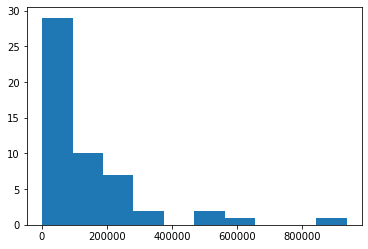

In [9]:
plt.hist(errors)

<AxesSubplot:>

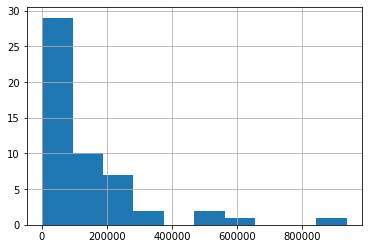

In [10]:
evaluation_result['MAE'].hist()

In [11]:
prediction_result['error'] = prediction_result.apply(lambda x : abs(x[2]-x[3]), axis=1)
prediction_result.head()

,geo_value,prediction_length,real_value,predicted_value,error
0,ak,1,15611.142857,10627.023438,4984.119420
1,ak,2,15985.142857,10748.681641,5236.461217
2,ak,3,16379.714286,10717.274414,5662.439872
3,ak,4,16797.571429,10679.133789,6118.437640
4,ak,5,17239.714286,10639.542969,6600.171317


## Boxplot of Absolute Error by prediction_length

<AxesSubplot:title={'center':'error'}, xlabel='prediction_length'>

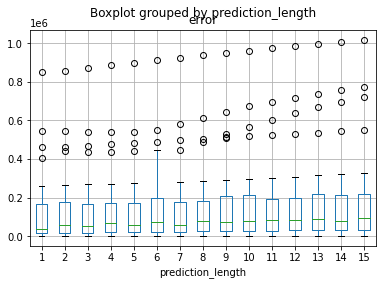

In [12]:
prediction_result.boxplot('error', by='prediction_length')